# XGBoost-based dengue case classification in Brazilian pediatric cohort using clinical and household features

# Executive Summary

In this notebook, I developed a machine learning classifier to predict symptomatic dengue cases among children and adolescents aged 2–16 years in Araraquara, Brazil, based on a prospective cohort study dataset of 3,514 participants. To identify individuals at a higher risk of confirmed dengue infection, the model uses three key predictors: **crowding index** (a measure of household density), **average fever duration across febrile episodes**, and **age**. Using XGBoost with Bayesian hyperparameter optimization, the model achieved a strong discriminatory performance (ROC AUC ~ 0.9) on the test set, with a high recall (0.97), indicating excellent sensitive detection of dengue cases, albeit with poor precision (0.30). This trade-off is important in public health contexts, where minimizing missed cases outweighs false alarms. This study demonstrates how demographic and clinical features can be effectively combined for dengue risk prediction, guiding surveillance and preventive interventions.

# Introduction

Dengue fever, a disease transmitted by Aedes mosquitoes, is a significant public health concern in Brazil and is caused by four main serotypes: DENV-1 to DENV-4 [[1; Chiaravalloti-Neto et al., 2019]](https://doi.org/10.1186/s12879-019-4074-4). Dengue infection can range from asymptomatic or mild febrile illness to severe forms such as dengue hemorrhagic fever and dengue shock syndrome, posing risks of serious complications and mortality [[2; Khetarpal & Khanna, 2016]](https://doi.org/10.1155/2016/6803098). Control efforts focus on vector management and public health interventions to reduce mosquito breeding sites and interrupt transmission [[3; Ghosh & Dar, 2015]](https://doi.org/10.4103/0255-0857.148369).
The economic burden of dengue in Brazil is substantial, driven by healthcare costs, lost productivity, and long-term morbidity, with children particularly vulnerable due to higher mortality rates and severe clinical manifestations [[4; Araújo et al., 2017]](https://doi.org/10.1590/1980-5497201700050017). Household density, captured here through a derived crowding index, is a critical factor influencing dengue transmission, as higher household occupancy increases contact rates with Aedes mosquitoes, thereby elevating infection risk [[5; Padmanabha et al., 2012]](https://doi.org/10.1371/journal.pntd.0001799). Rahman et al. [[6]](https://doi.org/10.3390/ijerph18115971) found out that that elevated household density correlates with increased dengue incidence, highlighting the importance of socio-environmental determinants in disease spread. This study focuses on constructing a robust classifier for symptomatic dengue using cohort data collected between 2014 and 2015, incorporating socio-demographic variables and detailed fever episode monitoring. I integrated the crowding index, average fever duration, and age to improve prediction of symptomatic dengue cases and devise targeted interventions.

# Methods

### Data Source

We analyzed data from a cohort of 3,514 children and adolescents aged 2–16 years enrolled in Araraquara from September 2014 to March 2015. Data included baseline demographics, household characteristics, and lab-confirmed dengue outcomes via PCR, NS1, and IgM assays collected weekly over multiple years. The data is sourced from [[7]](https://data.mendeley.com/datasets/n32bwynzr4/1).

The present cohort study was established to determine the incidence of dengue among children and adolescents aged 2 to 16 years living in Araraquara, South-Eastern Brazil, a city classified with mid-level endemicity for dengue. Enrollment occurred from September 2014 to March 2015. At baseline, socio-demographic data were collected from parents or legal guardians, and blood samples were drawn from participants for dengue serology. Families were contacted weekly for fever surveillance, and if a child developed fever, a nurse visited the household to collect a blood sample for diagnosis. Laboratory confirmation of dengue infection utilized PCR, NS1 antigen, and IgM assays. Written informed consent was obtained from all parents or guardians.

A total of 3,514 children and adolescents were enrolled. The dataset includes information collected during the enrollment interview (age, sex, household characteristics, sanitation, schooling of the household head), baseline and annual IgG serology results, and detailed fever surveillance data, which contain reported signs and symptoms, and dengue laboratory results (polymerase chain reaction/PCR, non-structural protein 1/NS1, immunoglobulin M/IgM, and immunoglobulin G/IgG). Additionally, derived variables indicate whether participants experienced a symptomatic laboratory-confirmed dengue episode, inapparent infections, and dengue virus serotypes detected in confirmed cases. Fever episode details include the recorded number of fever days per check-in visit, providing temporal insight into illness duration during surveillance.

In [13]:
# install necessary libraries to convert .sav to .csv
!pip install pandas pyreadstat


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


The original dataset was provided in SPSS `.sav` format. It was converted to `.csv` using the `pyreadstat` Python library to enable easy data manipulation with `pandas` and integration in the machine learning pipeline.

In [2]:
import pandas as pd
pd.set_option('display.max_rows', None)        # Show all rows
pd.set_option('display.max_seq_item', None)    # Show all items in sequences

# Define the input .sav file path and the output .csv file path
spss_file_path = "Dengue BRA.sav"
csv_file_path = "Dengue BRA.csv"

# Read the SPSS .sav file into a pandas DataFrame
df_dengue = pd.read_spss(spss_file_path)

# Export the DataFrame to a CSV file
# index=False prevents pandas from writing the DataFrame index as a column in the CSV
df_dengue.to_csv(csv_file_path, index=False)

print(f"Successfully converted '{spss_file_path}' to '{csv_file_path}'")


Successfully converted 'Dengue BRA.sav' to 'Dengue BRA.csv'


Let's check the columns of the dataset.

In [12]:
df_dengue.columns

Index(['study_id', 'Birth_date', 'Census_tract', 'Baseline_Serol_Date',
       'Baseline_Serol_result', 'Interview_date', 'Age', 'Sex',
       'Enrolledinschool', 'Schoolyear', 'Schoollevelofheadofhousehold',
       'Typeofhousehold', 'Apartment_floor', 'Numberofpeopleinhousehold',
       'Livingrooms', 'Bedrooms', 'Kitchen', 'Bathrooms',
       'Likedtowaternetwork', 'Waterfromwell', 'Waterfromtrucks',
       'Waterfromriver', 'Linkedtosewagenetwork', 'GarbageDestination',
       'Annual_serol_1_Date', 'AnnualSerol1result', 'Annual_serol_2_Date',
       'Annual_serol_2_result', 'Annual_serol_3_Date', 'Annual_serol_result',
       'Fever_1_Date_Blood_Draw', 'Fever_1_ELISA_IgG_Result',
       'Fever_1_ELISA_IgM_Result', 'Fever_1_NS1', 'Fever_1_RT_PCR',
       'Fever_1_GENOTYPE', 'Fever_1_Diagnosis', 'Fever_1_Daysoffever',
       'Fever_1_dateofonset', 'Fever_1_conjunctivalinjection',
       'Fever_1_Headache', 'Fever_1_Abdominalpain', 'Fever_1_Myalgia',
       'Fever_1_Arthralgia', 'Fev

Let's move over to the dataset. I will constrict it to only include the number of people in the household, number of living rooms/bedrooms/kitchen units, age, dengue case confirmation, and fever duration (in days).

In [8]:
# ----------------
# Filter df to only necessary columns at start
# ----------------

needed_cols = [
    'Numberofpeopleinhousehold', 'Livingrooms', 'Bedrooms', 'Kitchen',
    'Age',
    'Confirmeddenguecase'
] + [f'Fever_{i}_Daysoffever' for i in range(1, 11)]

df = df_dengue.loc[:, df_dengue.columns.intersection(needed_cols)].copy()

### Feature Engineering

To enhance the predictive power of the model and capture key aspects of dengue risk and clinical presentation, raw data variables were transformed and combined into meaningful features that better represented the underlying epidemiological and clinical patterns relevant to dengue infection.

- **Crowding Index  (c_i)**:  
The crowding index for household $i$ is calculated as the ratio of the total number of occupants to the total number of main living spaces (bedrooms, kitchens, and living rooms) in that household. It is formally defined as


    $c_i = \frac{O_i}{B_i + K_i + L_i}$

  where:  
  - $O_i$ = number of occupants in household $i$
  - $B_i$ = number of bedrooms in household $i$ 
  - $K_i$ = number of kitchens in household $i$
  - $L_i$ = number of living rooms in household $i$

  This metric serves as a proxy for household crowding and potential dengue exposure risk, with higher values indicating more occupants per unit of living space.

- **Average Fever Duration**:  
  Calculated as the mean number of reported fever days per febrile episode, averaged over up to ten monitored episodes per participant. This feature captures the duration of illness, which may be indicative of the severity of symptomatic dengue infection.

- **Age**:  
  Participants’ age at enrollment was used as a continuous numerical variable to adjust for age-related variations in dengue risk and clinical presentation.


### Preprocessing

The initial stage involved data preparation, which was necessary to improve the model quality and robustness. First, the dataset was filtered to retain only the columns deemed relevant for modeling based on domain knowledge and prior data exploration, thus reducing dimensionality and potential noise. Missing values within numeric features were imputed using the median strategy, a robust statistic less sensitive to outliers than the mean, ensuring data completeness without skewing distributions. Subsequently, all continuous numeric features were scaled to the $[0,1]$ interval using the MinMaxScaler, which preserves the original distribution shape while normalizing the feature ranges. This step facilitates efficient gradient-based model convergence and comparability across the heterogeneous feature scales. Finally, the dataset was split into training and testing subsets in an 80/20 ratio using stratified sampling based on the outcome variable to maintain the class proportions and reduce the sampling bias during model evaluation.

---

### Modeling

An XGBoost classification algorithm was employed, leveraging its gradient-boosted decision tree framework, which is known for its robust handling of tabular, mixed-type data, and complex feature interactions. To optimize the model performance, Bayesian hyperparameter tuning was performed over critical parameters affecting the model complexity, regularization, and subsampling behavior, including:  
- *max_depth*: controls tree depth and thus model capacity to learn interactions  
- *gamma*: minimum loss reduction required for further partitioning, serving as a pruning parameter  
- *colsample_bytree* and *subsample*: fractions of features and observations sampled per tree to mitigate overfitting  
- *min_child_weight*: minimum sum of instance weight needed in a child node, controlling model sensitivity to outliers  
- *learning_rate*: step size shrinkage for weight updates to improve convergence stability

To address the inherent class imbalance in symptomatic dengue incidence, the scale_pos_weight parameter was adjusted. This weighting increased the penalty for misclassifying positive (dengue) cases, thereby promoting sensitivity without severely compromising specificity.

---

### Evaluation

The model generalizability and predictive discrimination were assessed using the independent test set. The primary evaluation metric was the Receiver Operating Characteristic Area Under the Curve (ROC AUC), which was chosen for its ability to summarize classifier performance across all possible thresholds without dependence on class prevalence. To gain operational insight into the classification trade-offs at a specific decision threshold, additional metrics were calculated: precision (positive predictive value), recall (sensitivity), F1 score (harmonic mean of precision and recall), and accuracy. The classification threshold was selected by maximizing the F1 score on the validation data, emphasizing the balance between false positives and false negatives, which is critical for clinical relevance in dengue diagnosis.

---

### Model Building

The model training pipeline incorporated a systematic hyperparameter search using Bayesian optimization to explore the parameter space efficiently. The process began with five random parameter samples ("initial points") to construct a surrogate performance landscape, followed by five iterations of informed sampling that leveraged previous evaluations to propose new configurations targeting increased cross-validated ROC AUC within the training folds. After identifying the optimal hyperparameters, the final XGBoost model was trained on the entire training dataset, with early stopping applied based on the performance on a hold-out validation subset to prevent overfitting. Subsequently, the predicted probabilities for the test instances were generated. To translate these probabilities into binary predictions, the classification threshold was optimized to maximize the F1 score, ensuring a practical balance between sensitivity and specificity, which was aligned with clinical priorities.


In [9]:
# install necessary libraries for modeling
!pip install pandas numpy scikit-learn xgboost bayesian-optimization


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


Starting Bayesian Optimization...
|   iter    |  target   | max_depth |   gamma   | colsam... | subsample | min_ch... | learni... |
-------------------------------------------------------------------------------------------------
| 1         | 0.8915146 | 5.6217808 | 4.7535715 | 0.8123957 | 0.7190609 | 2.4041677 | 0.0552384 |
| 2         | 0.8952910 | 3.4065852 | 4.3308807 | 0.7207805 | 0.7956508 | 1.1852604 | 0.2912738 |
| 3         | 0.8834735 | 8.8270984 | 1.0616955 | 0.4272774 | 0.4283831 | 3.7381801 | 0.1621793 |
| 4         | 0.8925193 | 6.0236151 | 1.4561457 | 0.7282970 | 0.3976457 | 3.6293018 | 0.1162449 |
| 5         | 0.8813054 | 6.1924898 | 3.9258798 | 0.4397716 | 0.6599641 | 6.3317311 | 0.0234706 |
| 6         | 0.8941123 | 4.2415592 | 3.9885026 | 0.7546296 | 0.6932654 | 1.7963621 | 0.2132380 |
| 7         | 0.8946918 | 3.0       | 0.5997073 | 1.0       | 0.4696592 | 1.1102275 | 0.2207392 |
| 8         | 0.8936956 | 3.0       | 0.0       | 1.0       | 1.0       | 4.4844180 

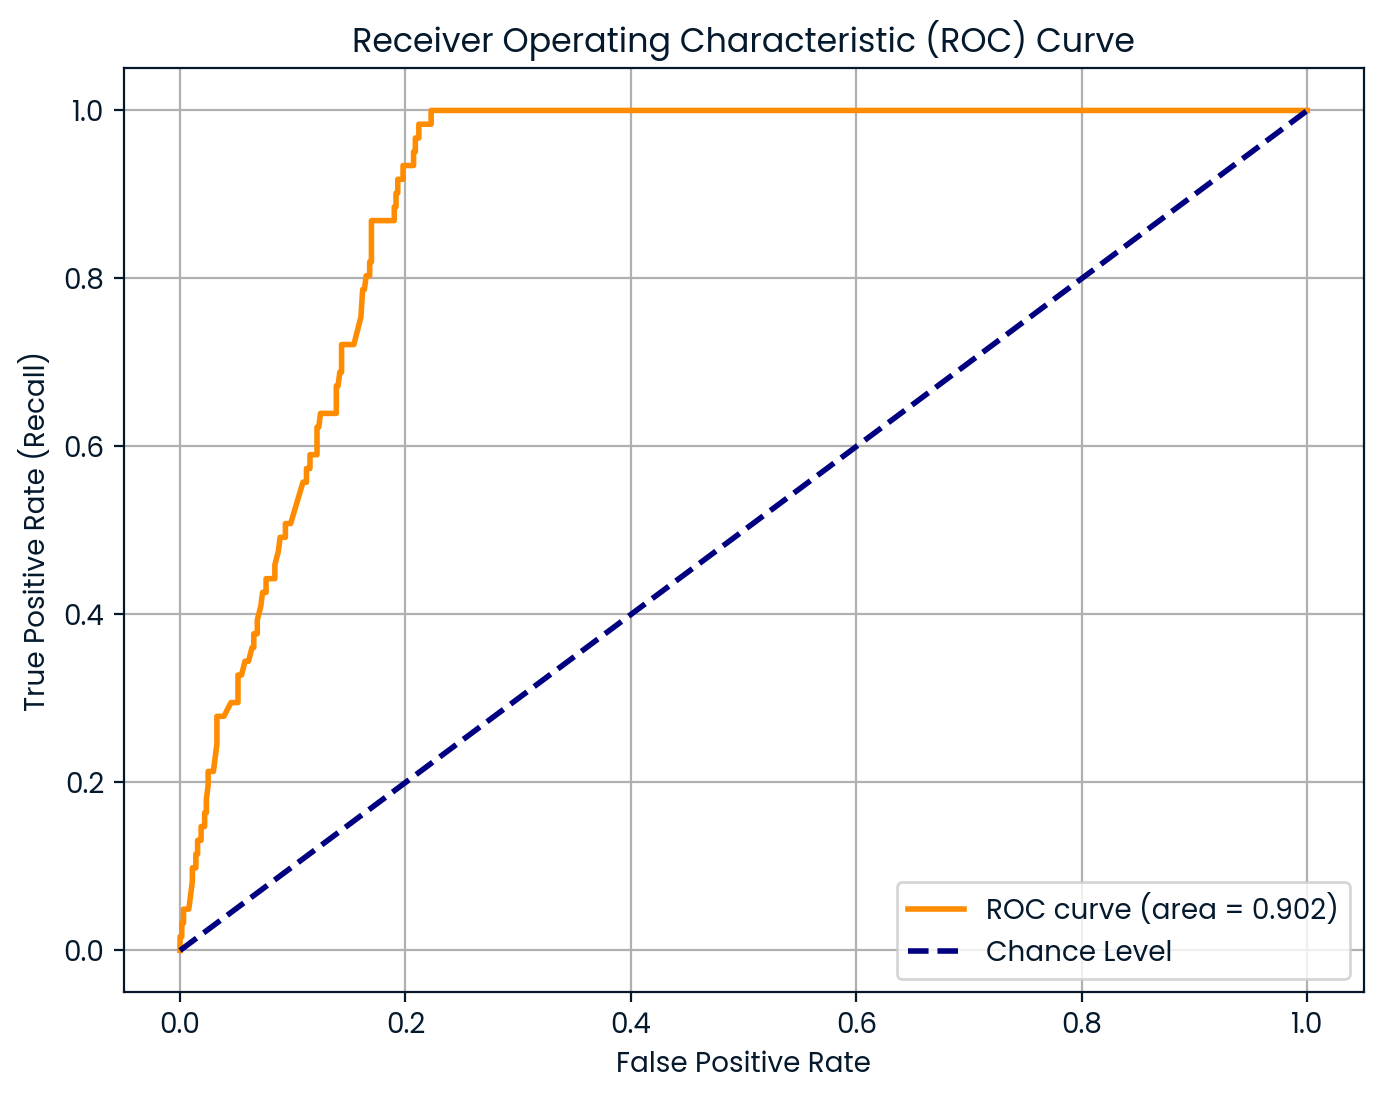

In [14]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score, f1_score, accuracy_score,
    roc_curve, precision_recall_curve
)
import matplotlib.pyplot as plt
import xgboost as xgb
from bayes_opt import BayesianOptimization


# ----------------
# Feature engineering functions
# ----------------

def aggregate_fever_features(df):
    # Create lists for PCR test results and fever days columns
    fever_pcr_cols = [f'Fever_{i}_RT_PCR' for i in range(1, 11)]
    fever_daysoffever_cols = [f'Fever_{i}_Daysoffever' for i in range(1, 11)]

    # Ensure all fever columns exist in the DataFrame, filling missing ones with NaN
    for col in fever_pcr_cols + fever_daysoffever_cols:
        if col not in df.columns:
            df[col] = np.nan

    # Initialize lists to store results for each patient
    pcr_positive_counts, max_days, avg_days = [], [], []

    # Iterate over each row of the DataFrame
    for _, row in df.iterrows():
        pcr_count = 0
        days_list = []
        # Check each PCR result and associated days
        for pcr_col, day_col in zip(fever_pcr_cols, fever_daysoffever_cols):
            pcr_result = row.get(pcr_col, '')
            days = row.get(day_col, np.nan)

            # Check for positive results
            pcr_positive = isinstance(pcr_result, str) and (pcr_result.strip().lower() == 'positive')
            if pcr_positive:
                pcr_count += 1

            # Collect days of fever, if valid
            if pd.notna(days):
                try:
                    days_list.append(float(days))
                except Exception:
                    pass

        # Store computed values in lists
        pcr_positive_counts.append(pcr_count)
        max_days.append(np.max(days_list) if days_list else 0.0)
        avg_days.append(np.mean(days_list) if days_list else 0.0)

    # Add computed features to the DataFrame
    df['fever_pcr_positive_count'] = pcr_positive_counts
    df['fever_max_daysoffever'] = max_days
    df['fever_avg_daysoffever'] = avg_days
    return df

def calculate_crowding_index(df):
    # Ensure the household size column exists, filling missing with NaN
    if 'Numberofpeopleinhousehold' not in df.columns:
        df['Numberofpeopleinhousehold'] = np.nan

    # Convert the household size to numeric and calculate median
    np_people_raw = pd.to_numeric(df['Numberofpeopleinhousehold'], errors='coerce')
    median_people = np_people_raw.median()
    np_people = np_people_raw.fillna(median_people)

    # Ensure room-related columns exist, filling missing with 0
    rooms_cols = ['Livingrooms', 'Bedrooms', 'Kitchen']
    for col in rooms_cols:
        if col not in df.columns:
            df[col] = 0

    # Sum the number of rooms for each entry, handling non-numeric gracefully
    rooms_sum = df[rooms_cols].apply(pd.to_numeric, errors='coerce').fillna(0).sum(axis=1)
    rooms_sum = rooms_sum.replace(0, np.nan)

    # Calculate the crowding index as the ratio of people to rooms
    base_ratio = np_people / rooms_sum
    crowding_index = base_ratio.fillna(base_ratio.median())
    df['crowding_index'] = crowding_index
    return df

# List of categorical columns to drop
cat_cols_to_drop = ['Typeofhousehold', 'Likedtowaternetwork', 'Waterfromwell', 'Waterfromriver', 'Linkedtosewagenetwork']

def preprocess_features_train_drop_cat(df_train, cat_cols):
    # Drop categorical columns and create a copy of the DataFrame for processing
    df_num = df_train.drop(columns=cat_cols, errors='ignore').copy()

    # Define the numeric columns for imputation and scaling
    num_cols = ['crowding_index', 'fever_avg_daysoffever', 'Age']

    # Ensure the numeric columns exist and convert them to numeric
    for col in num_cols:
        if col not in df_num.columns:
            df_num[col] = np.nan
        df_num[col] = pd.to_numeric(df_num[col], errors='coerce')

    # Initialize the imputer
    imputer = SimpleImputer(strategy='median')
    # Impute missing values
    df_num_imputed = pd.DataFrame(imputer.fit_transform(df_num[num_cols]),
                                  columns=num_cols, index=df_num.index)

    # Initialize and apply the scaler
    scaler = MinMaxScaler()
    df_num_scaled = pd.DataFrame(scaler.fit_transform(df_num_imputed),
                                 columns=num_cols, index=df_num.index)

    return df_num_scaled, imputer, scaler

def preprocess_features_test_drop_cat(df_test, cat_cols, imputer, scaler):
    # Drop categorical columns from the test DataFrame
    df_num = df_test.drop(columns=cat_cols, errors='ignore').copy()

    # Ensure numeric columns exist and convert them to numeric
    num_cols = ['crowding_index', 'fever_avg_daysoffever', 'Age']
    for col in num_cols:
        if col not in df_num.columns:
            df_num[col] = np.nan
        df_num[col] = pd.to_numeric(df_num[col], errors='coerce')

    # Impute and scale test features using the previously fitted imputer and scaler
    df_num_imputed = pd.DataFrame(imputer.transform(df_num[num_cols]),
                                  columns=num_cols, index=df_num.index)
    df_num_scaled = pd.DataFrame(scaler.transform(df_num_imputed),
                                 columns=num_cols, index=df_num.index)

    return df_num_scaled

# ----------------
# Main pipeline
# ----------------

# Aggregate fever features based on input DataFrame
df = aggregate_fever_features(df)
# Calculate crowding index based on the input DataFrame
df = calculate_crowding_index(df)

# Check for the target column 'Confirmeddenguecase'
if 'Confirmeddenguecase' not in df.columns:
    raise ValueError("Column 'Confirmeddenguecase' not found!")

# Convert the target variable to numeric and prepare mask for valid entries
y_raw = pd.to_numeric(df['Confirmeddenguecase'], errors='coerce').clip(0,1).astype(int)
mask = y_raw.notna()
df = df.loc[mask]
y_raw = y_raw.loc[mask]

# Split the dataset into training and testing sets
X_raw_train, X_raw_test, y_train, y_test = train_test_split(
    df, y_raw,
    test_size=0.2,
    stratify=y_raw,
    random_state=42
)

# Preprocess the training data (impute and scale)
X_train, imputer, scaler = preprocess_features_train_drop_cat(X_raw_train, cat_cols_to_drop)
# Preprocess the test data using fitted imputer and scaler
X_test = preprocess_features_test_drop_cat(X_raw_test, cat_cols_to_drop, imputer, scaler)

# Calculate scale positive weight for XGBoost
num_pos = float((y_train == 1).sum())
num_neg = float((y_train == 0).sum())
scale_pos_weight = num_neg / max(1.0, num_pos)

# Prepare the training data for XGBoost
dtrain_train = xgb.DMatrix(X_train, label=y_train)

def xgb_evaluate(max_depth, gamma, colsample_bytree, subsample, min_child_weight, learning_rate):
    # Define parameters for XGBoost model evaluation
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'max_depth': int(round(max_depth)),
        'gamma': float(gamma),
        'colsample_bytree': max(min(colsample_bytree, 1), 0),
        'subsample': max(min(subsample, 1), 0),
        'min_child_weight': int(round(min_child_weight)),
        'learning_rate': float(learning_rate),
        'scale_pos_weight': scale_pos_weight,
        'seed': 42,
        'verbosity': 0,
    }
    # Perform cross-validation to evaluate the model
    cv_results = xgb.cv(
        params=params,
        dtrain=dtrain_train,
        num_boost_round=100,
        nfold=5,
        early_stopping_rounds=10,
        stratified=True,
        seed=42,
        verbose_eval=False,
    )
    return cv_results['test-auc-mean'].max()

# Initialize Bayesian Optimization for hyperparameter tuning
xgb_bo = BayesianOptimization(
    f=xgb_evaluate,
    pbounds={
        'max_depth': (3, 10),
        'gamma': (0, 5),
        'colsample_bytree': (0.3, 1),
        'subsample': (0.3, 1),
        'min_child_weight': (1, 10),
        'learning_rate': (0.01, 0.3)
    },
    random_state=42,
    verbose=2
)

print("Starting Bayesian Optimization...")
# Execute the Bayesian optimization
xgb_bo.maximize(init_points=5, n_iter=5)

# Retrieve the best hyperparameters
best_params = xgb_bo.max['params']
print("\nBest hyperparameters found:")
print(best_params)

# Define final parameters based on the best found hyperparameters
final_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': int(round(best_params['max_depth'])),
    'gamma': float(best_params['gamma']),
    'colsample_bytree': float(best_params['colsample_bytree']),
    'subsample': float(best_params['subsample']),
    'min_child_weight': int(round(best_params['min_child_weight'])),
    'eta': float(best_params['learning_rate']),
    'scale_pos_weight': scale_pos_weight,
    'seed': 42,
    'verbosity': 1,
}

# Prepare final training and validation matrices
dtrain_final = xgb.DMatrix(X_train, label=y_train)
dvalid_final = xgb.DMatrix(X_test, label=y_test)

# Train the final XGBoost model using the best parameters
bst = xgb.train(
    params=final_params,
    dtrain=dtrain_final,
    num_boost_round=1000,
    evals=[(dvalid_final, 'valid')],
    early_stopping_rounds=20,
    verbose_eval=True,
)

# Predict probabilities on the test set
y_pred_proba = bst.predict(dvalid_final, iteration_range=(0, bst.best_iteration + 1))

# Calculate the ROC-AUC score for test predictions
auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nFinal Test ROC-AUC = {auc:.4f}")

# Tune classification threshold based on maximum F1 score
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)
f1_scores = 2*precisions*recalls/(precisions+recalls+1e-16)  # avoid div zero
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Best classification threshold for max F1: {best_threshold:.3f}")

# Classify predictions using the tuned threshold
y_pred_class = (y_pred_proba >= best_threshold).astype(int)

# Calculate metrics at the best threshold level
precision = precision_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)
accuracy = accuracy_score(y_test, y_pred_class)

print(f"Precision at best threshold: {precision:.4f}")
print(f"Recall at best threshold:    {recall:.4f}")
print(f"F1 Score at best threshold:  {f1:.4f}")
print(f"Accuracy at best threshold:  {accuracy:.4f}")

# Plot ROC Curve for visual assessment of model performance
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc:.3f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--', label='Chance Level')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Results

The model effectively identified symptomatic dengue cases with a very high recall of 96.7%, indicating that very few true-positive cases were missed. This high sensitivity is crucial in public health and clinical settings, where the risk of overlooking infected individuals can have serious consequences. However, the precision was poor at 30.3%, reflecting a relatively high false-positive rate. Although this indicates that a sizable proportion of cases predicted to be positive are not true cases, such a trade-off is often acceptable in surveillance contexts where maximizing detection is more important than minimizing false alarms.

The area under the ROC curve (ROC AUC) of approximately 0.902 indicates excellent discriminatory capability of the model. The ROC curve consistently remained well above the chance line, demonstrating the capability to distinguish symptomatic dengue cases from non-cases across varying classification thresholds. Additionally, an accuracy of over 80% confirms a stable overall performance, although accuracy should be interpreted cautiously in the presence of class imbalance.

These results highlight the model’s utility in automated dengue surveillance systems, where capturing as many true cases as possible is critical, even at the expense of an increased number of false positives. The strong discrimination reflected by the ROC AUC and the balance provided by the optimized threshold ensure that the model can serve as a valuable decision-support tool for disease detection and control efforts.


# Discussion
The model’s strong recall performance is suitable for public health priorities focused on early dengue case identification. The crowding index and fever duration capture environmental and clinical risk factors relevant to transmission and symptom severity. Age remains an important demographic predictor of observed incidence trends. 

The low precision highlights the need to balance false alarms, which can strain resources. Future improvements could incorporate additional clinical features, temporal data (e.g., time since the last dengue season), or serological markers to enhance specificity.

# Future Work
To further improve the predictive performance of the model, future efforts should focus on expanding the range of input features by including more clinical symptoms, laboratory test results, and environmental factors that are known to influence dengue risk. Additionally, incorporating longitudinal or temporal data can help capture important patterns, such as seasonal trends and changes in individual health status over time, providing a richer context for prediction. To ensure the model’s robustness and usefulness beyond the original study population, external validation of datasets from different geographic regions or patient cohorts will be necessary to evaluate generalizability. Finally, practical deployment will involve integrating the predictive system into existing public health surveillance workflows, supported by intuitive risk dashboards to assist health professionals in making timely and informed decisions.


# Conclusion
I developed a dengue risk classifier using the crowding index, average fever duration, and age, trained on a robust pediatric cohort in Brazil. The model achieved very high sensitivity and strong overall discrimination, making it a valuable tool for early detection and epidemiological surveillance in dengue-endemic areas. With further refinement and broader validation, it holds promise for supporting targeted prevention efforts and reducing the dengue burden. 

Should you have questions, kindly send them at jprmaulion[at]gmail[dot]com. Cheers!